In [23]:
import collections
import itertools
import json
import pathlib

from jax import tree_util
import matplotlib
from matplotlib import pyplot as plt
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import hier_torch
import infer
import main
import metrics
import progmet

In [2]:
device = torch.device('cuda')

In [3]:
import configs.imagenet_linear

base_config = configs.imagenet_linear.get_config()
base_config.dataset_root = './resources/features/imagenet_vitb32/'

_, eval_dataset, tree, _, _, eval_label_map = main.make_datasets(base_config)

In [4]:
eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=8)

In [34]:
is_leaf = tree.leaf_mask()
specificity = -tree.num_leaf_descendants()
not_trivial = (tree.num_children() != 1)
subtract_children_fn = hier_torch.SubtractChildren(tree)

In [35]:
infer_fns = {
    'leaf': lambda p: infer.argmax_where(p, is_leaf),
    'majority': lambda p: infer.argmax_with_confidence(specificity, p, 0.5, not_trivial),
    'exclusive': lambda p: np.argmax(subtract_children_fn(torch.from_numpy(p)).numpy(), axis=-1),
}

In [36]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)

metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_excess': info_metric.excess,
    'info_deficient': info_metric.deficient,
    'info_dist': info_metric.dist,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'depth_excess': depth_metric.excess,
    'depth_deficient': depth_metric.deficient,
    'depth_dist': depth_metric.dist,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
}

In [37]:
Experiment = collections.namedtuple('Experiment', ['config_file', 'model_file'])

def standard_experiment(experiment_dir, epoch):
    return Experiment(
        config_file=pathlib.Path(experiment_dir) / 'config.json',
        model_file=pathlib.Path(experiment_dir) / f'checkpoints/epoch-{epoch:04d}.pth',
    )

In [38]:
results = {}

In [39]:
# experiments = {
#     'flat-lr{lr}-wd{wd}-ep{ep}': standard_experiment(
#         experiment_dir=f'/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-25-imagenet-features/vitb32-linear-flat_softmax-lr{lr}-wd{wd}-ep{ep}/',
#         epoch=int(ep))
#     for lr, wd, ep in itertools.product(['0.1', '0.01', '0.001'], ['0.0001', '0.00001'], ['20', '100'])
# }

experiments = {
    'flat': standard_experiment(
        experiment_dir=f'/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-25-imagenet-features/vitb32-linear-flat_softmax-lr0.1-wd0.00001-ep20/',
        epoch=20),
    'soft-margin-incorrect-5': standard_experiment(
        experiment_dir=f'/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-25-imagenet-features/vitb32-linear-soft_margin-incorrect-5-lr0.1-wd0.00001-ep20/',
        epoch=20),
}

In [40]:
{name: pathlib.Path(experiment.config_file).exists() for name, experiment in experiments.items()}

{'flat': True, 'soft-margin-incorrect-5': True}

In [50]:
markers = {
    'leaf': 'x',
    'majority': 's',
    'exclusive': 'd',
}

colors = dict(zip(
    experiments,
    map(matplotlib.cm.get_cmap('tab10'), itertools.count())))

In [42]:
def apply_model(net, pred_fn, min_threshold):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {method: [] for method in infer_fns},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': [],
        'prob': [],
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in itertools.islice(meter(eval_loader), None):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            prob = pred_fn(theta).cpu().numpy()
            pred = {}
            for name, infer_fn in infer_fns.items():
                pred[name] = infer_fn(prob)
            gt_node = eval_label_map.to_node[gt_labels]
            pred_seqs = [
                infer.pareto_optimal_predictions(specificity, p, min_threshold, not_trivial)
                for p in prob
            ]
            prob_seqs = [prob[i, pred_i] for i, pred_i in enumerate(pred_seqs)]
            # Caution: Predictions are *not* truncated.

            outputs['gt'].append(gt_node)
            for method in infer_fns:
                outputs['pred'][method].append(pred[method])
            seq_outputs['pred'].extend(pred_seqs)
            seq_outputs['prob'].extend(prob_seqs)

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [43]:
def assess_predictions(outputs, seq_outputs):
    gt = outputs['gt']
    pred = outputs['pred']
    pred_seq = seq_outputs['pred']
    prob_seq = seq_outputs['prob']

    # Evaluate predictions for each method.
    pred = {
        method: hier.truncate_at_lca(tree, gt, pr)
        for method, pr in pred.items()
    }
    pred_metrics = {
        method: {field: np.mean(metric_fn(gt, pr))
                 for field, metric_fn in metric_fns.items()}
        for method, pr in pred.items()
    }

    # Evaluate predictions in Pareto sequence.
    find_lca = hier.FindLCA(tree)
    specificity_seq = [specificity[pr_i] for pr_i in pred_seq]
    pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
    metric_values_seq = {
        field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
        for field, metric_fn in metric_fns.items()
    }
    pareto_scores, pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
#     specificity_seq = [np.flip(seq) for seq in specificity_seq]
#     metric_values_seq = {field: np.flip(seq) for field, seq in metric_values_seq.items()}
#     pareto_scores, pareto_totals = metrics.operating_curve(specificity_seq, metric_values_seq)
    pareto_means = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [44]:
MIN_THRESHOLD = 0.1  # Values less than 0.5 may increase runtime significantly.

for name, (config_file, model_file) in experiments.items():
    if name in results:
        print('cached:', name)
        continue

    # Load model.
    with open(config_file, 'r') as f:
        config = ml_collections.ConfigDict(json.load(f))
    num_outputs = main.get_num_outputs(config.predict, tree)
    net = main.make_model(config.model, num_outputs)
    missing_keys, unexpected_keys = net.load_state_dict(torch.load(model_file), strict=True)
    assert not missing_keys
    assert not unexpected_keys

    net.to(device)
    _, pred_fn = main.make_loss(config, tree, device)
    outputs, seq_outputs = apply_model(net, pred_fn, min_threshold=MIN_THRESHOLD)
    pred_metrics, pareto_scores, pareto_metrics = assess_predictions(outputs, seq_outputs)
    results[name] = {
        'pred_metrics': pred_metrics,
        'pareto_scores': pareto_scores,
        'pareto_metrics': pareto_metrics,
    }

apply:  77% (150/196); T=0.0335 f=29.9; mean T=0.0335 f=29.9; elapsed 0:00:05; remaining 0:00:02 of 0:00:07
apply: 100% (196/196); T=0.0354 f=28.2; mean T=0.0340 f=29.5; elapsed 0:00:07
apply:  76% (148/196); T=0.0340 f=29.4; mean T=0.0340 f=29.4; elapsed 0:00:05; remaining 0:00:02 of 0:00:07
apply: 100% (196/196); T=0.0311 f=32.2; mean T=0.0333 f=30.0; elapsed 0:00:07


In [45]:
INTEGRALS = [
    ('depth_recall', 'correct'),
    ('depth_recall', 'depth_precision'),
    ('info_recall', 'info_precision'),
    ('exact', 'correct'),
]

auc = {
    f'∫ {y} d({x})': {
        name: metrics.pareto_integrate(
            results[name]['pareto_metrics'][x],
            results[name]['pareto_metrics'][y])
        for name in results
    } for x, y in INTEGRALS
}

pd.DataFrame(auc)

,∫ correct d(depth_recall),∫ depth_precision d(depth_recall),∫ info_precision d(info_recall),∫ correct d(exact)
flat,0.839986,0.851669,0.766619,0.711170
soft-margin-incorrect-5,0.841160,0.852454,0.771491,0.721322


In [46]:
INTERCEPTS = [
    'depth_recall',
    'info_recall',
    'exact',
]

CORRECT = 0.9

recalls = {
    f'{y} @ {CORRECT} correct': {
        name: metrics.pareto_intercept(
            results[name]['pareto_metrics']['correct'],
            results[name]['pareto_metrics'][y],
            CORRECT)
        for name in results
    } for y in INTERCEPTS
}

pd.DataFrame(recalls)

,depth_recall @ 0.9 correct,info_recall @ 0.9 correct,exact @ 0.9 correct
flat,0.774084,0.654071,0.58170
soft-margin-incorrect-5,0.786067,0.685514,0.63084


In [51]:
def plot_metrics(x, y, threshold=0.5):
    for name in results:
        pred_metrics = results[name]['pred_metrics']
        pareto_scores = results[name]['pareto_scores']
        pareto_metrics = results[name]['pareto_metrics']
        ge = np.concatenate(([True], pareto_scores >= threshold))
        le = np.concatenate(([False], pareto_scores <= threshold))
        plt.plot(pareto_metrics[x][ge], pareto_metrics[y][ge],
                 color=colors[name], label=name)
        plt.plot(pareto_metrics[x][le], pareto_metrics[y][le],
                 color=colors[name], alpha=0.5)  # linestyle=':')
        for method, method_metrics in pred_metrics.items():
            plt.plot(method_metrics[x], method_metrics[y], color=colors[name],
                     marker=markers[method], markerfacecolor='none')
    plt.ylim(top=1)
    plt.xlim(left=0)
    # plt.axis('equal')
    # plt.gca().set_aspect(1)markers = {
    'leaf': 's',
    'majority': 'o',
}
    plt.grid()
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

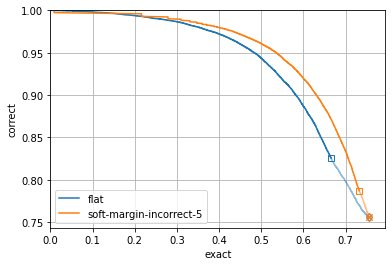

In [52]:
plot_metrics('exact', 'correct')

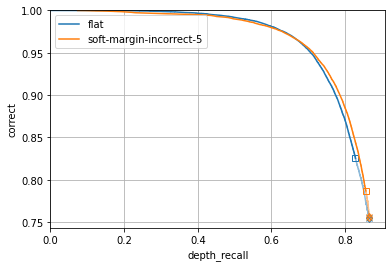

In [57]:
plot_metrics('depth_recall', 'correct')

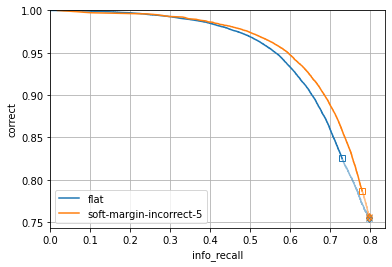

In [56]:
plot_metrics('info_recall', 'correct')

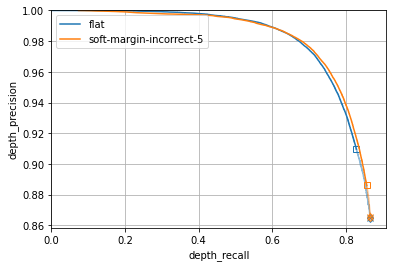

In [54]:
plot_metrics('depth_recall', 'depth_precision')

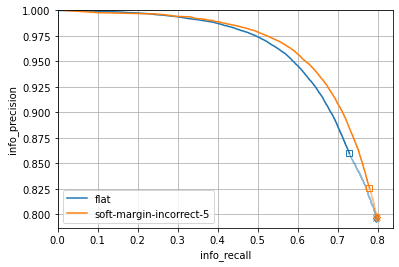

In [55]:
plot_metrics('info_recall', 'info_precision')